*I tried to predict a news category with a DistilBert based Tensorflow model.*

* I applied several <b>preprocessing</b> operations (cleaning,dropping stop words, lemmatizing),
* Used tf.data pipeline for efficient training,
* I only used 100 max length for sequence length (bert models support up to 512 input lengths)
* Only 1065 samples be used for training,  (710 samples for validating and 2664 samples for testing)


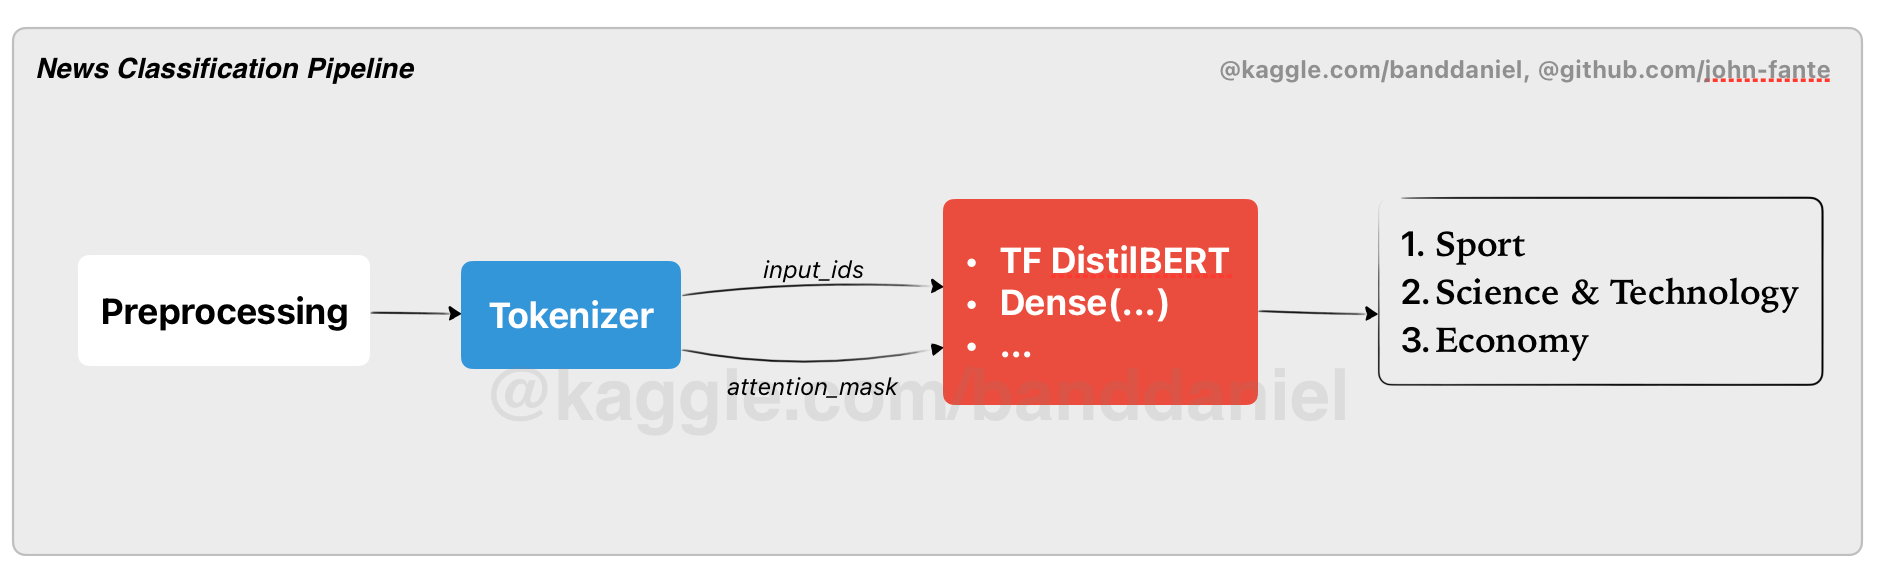


## My Another Projects
* [Complaint Analysis w/Ensemble Model (CatBoost, LR)](https://www.kaggle.com/code/banddaniel/complaint-analysis-w-ensemble-model-catboost-lr)
* [Gemma 2B Text Summarization w/Zero-Shot Prompting](https://www.kaggle.com/code/banddaniel/gemma-2b-text-summarization-w-zero-shot-prompting)
* [Rating Prediction w/SentenceTransformer, CatBoost](https://www.kaggle.com/code/banddaniel/rating-prediction-w-sentencetransformer-catboost)


## References
1. https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379
2. https://www.kaggle.com/code/preatcher/emotion-detection-by-using-bert

In [1]:
# downgrade tensorflow for using huggingface distilbert model as embedding

from IPython.display import clear_output
!pip uninstall tensorflow -y
!pip install tensorflow==2.9.0
!pip install --user -U nltk spacy
clear_output()

In [2]:
import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import *

from transformers import AutoTokenizer, TFDistilBertModel, DistilBertTokenizer, DistilBertConfig


SEED = 500
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

In [3]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
distil_bert = TFDistilBertModel.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


# <span style="color:#e74c3c;"> Reading </span> Data

In [4]:
df1 = pd.read_csv('/kaggle/input/aljazeera-news-dataset/df.csv')
df2 = pd.read_csv('/kaggle/input/aljazeera-news-dataset/economy.csv')
df3 = pd.read_csv('/kaggle/input/aljazeera-news-dataset/tech.csv')

# concat three dataframes and shuffling
full_data = pd.concat([df1, df2, df3], ignore_index = True).sample(frac = 1).reset_index(drop = True)

# <span style="color:#e74c3c;"> Preprocessing </span>

In [5]:
# preprocessing functions

stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text

def lemmatization(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)    
    return lemmatized_text


# applying preprocessing functions 
full_data['preprocessed_article'] = full_data['article_content'].apply(text_preprocessing).apply(drop_stopwords).apply(lemmatization)

# label encoding
le = LabelEncoder()
full_data['encoded_category'] = le.fit_transform(full_data['category'].tolist())

In [6]:
full_data.head()

,category,title,article_content,preprocessed_article,encoded_category
0,Economy,Russia gas cuts stoke Asia’s energy security f...,Analysts say disruptions to Nord Stream 1 pipe...,analyst say disruption nord stream pipeline co...,0
1,Science & Technology,AI brings century-old footage back to life,Developers use AI tools to bring life to centu...,developer use ai tool bring life century old f...,1
2,Sports,Recap: Brazil vs South Korea – World Cup 2022,Brazil score four first-half goals to cruise p...,brazil score four first half goal cruise past ...,2
3,Science & Technology,Facebook: Canada’s banks join ad boycott to bl...,More than 400 brands have pulled advertising o...,brand pull advertising facebook response stop ...,1
4,Economy,Chinese-Canadian billionaire Xiao sentenced to...,Shanghai court says tycoon Xiao Jianhua carrie...,shanghai court say tycoon xiao jianhua carry c...,0


In [7]:
# train and test splitting

train_val_data, test_data = train_test_split(full_data, test_size = 0.6, random_state = SEED, stratify = full_data['encoded_category'])
train_data, val_data = train_test_split(train_val_data, test_size = 0.4, random_state = SEED, stratify = train_val_data['encoded_category'])


print('train samples :\t', train_data.shape[0])
print('val samples :\t', val_data.shape[0])
print('test samples :\t', test_data.shape[0])

train samples :	 1065
val samples :	 710
test samples :	 2664


# <span style="color:#e74c3c;"> Tokenizing </span>

In [8]:
MAX_LEN = 100

X_train = tokenizer(text=train_data['preprocessed_article'].tolist(), add_special_tokens=True,
                    max_length= MAX_LEN, truncation=True, padding=True, return_tensors='tf',
                    return_token_type_ids=False, return_attention_mask=True, verbose=True)

X_valid = tokenizer(text=val_data['preprocessed_article'].tolist(), add_special_tokens=True,
                    max_length= MAX_LEN, truncation=True, padding=True, return_tensors='tf',
                    return_token_type_ids=False, return_attention_mask=True, verbose=True)

X_test = tokenizer(text=test_data['preprocessed_article'].tolist(), add_special_tokens=True,
                   max_length= MAX_LEN, truncation=True, padding=True, return_tensors='tf',
                   return_token_type_ids=False, return_attention_mask=True, verbose=True)

# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [9]:
# a function for tf.data pipeline
def parsing(text, label):
    input_ids = text['input_ids']
    attention_mask = text['attention_mask']
    
    return {'input_ids': input_ids, 'attention_mask' : attention_mask}, label

In [10]:
train_loader = tf.data.Dataset.from_tensor_slices((X_train, train_data['encoded_category']))
train_dataset = (train_loader.map(parsing, num_parallel_calls = AUTO).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE).prefetch(AUTO))

valid_loader = tf.data.Dataset.from_tensor_slices((X_valid, val_data['encoded_category']))
valid_dataset = (valid_loader.map(parsing, num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((X_test, test_data['encoded_category']))
test_dataset = (test_loader.map(parsing, num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))

In [11]:
# a test sample after tokenizing (max length is 100)

sample = list(test_dataset.take(1))

decoded_sample = tokenizer.decode(sample[0][0]['input_ids'][0].numpy())
decoded_sample

'[CLS] report find maiden pharmaceutical medicine may linked death dozen child african nation indian health authority say wednesday halt production new delhi base maiden pharmaceutical report cough cold syrup export gambia may link death dozen child know pharmacy world india supply percent generic medicine africa deaths child gambia one bad incident involve drug india come blow industry whose export double last decade hit last fiscal year indian authority inspect maiden main factory state haryana four time month say suspend manufacturing activity tuesday find firm manufacturing testing drug violation rule across manufacture testing activity view seriousness contravention observe [SEP]'

In [12]:
# a test sample before tokenizing

test_data['preprocessed_article'].iloc[0]

'report find maiden pharmaceutical medicine may linked death dozen child african nation indian health authority say wednesday halt production new delhi base maiden pharmaceutical report cough cold syrup export gambia may link death dozen child know pharmacy world india supply percent generic medicine africa deaths child gambia one bad incident involve drug india come blow industry whose export double last decade hit last fiscal year indian authority inspect maiden main factory state haryana four time month say suspend manufacturing activity tuesday find firm manufacturing testing drug violation rule across manufacture testing activity view seriousness contravention observe investigation potential risk quality safety efficacy drug produce manufacturing activity firm stop immediate effect say order federal haryana state drug regulator maiden executive naresh kumar goyal decline comment tell reuters news agency last week company trying find buyer happen gambia drug export gambia make maid

# <span style="color:#e74c3c;"> TFDistilBert </span>  Model

In [13]:
input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")
embeddings = distil_bert(input_ids, attention_mask = input_mask)[0] 

X = GlobalMaxPool1D()(embeddings)
X = Dense(256, activation='gelu')(X)
X = Dropout(0.3)(X)
X = Dense(64,activation = 'gelu')(X)
X = Dropout(0.1)(X)
out = Dense(3,activation = 'softmax')(X)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=out)


# for distilbert training
model.layers[2].trainable = True

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=5e-05), loss = tf.keras.losses.SparseCategoricalCrossentropy(),  metrics = ['acc'] )
model.summary()

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, min_delta = 0.001),
                tf.keras.callbacks.ModelCheckpoint('/kaggle/working/model.best.weights.h5', save_best_only=True, save_weights_only=True)]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 100, 768),                                                   
                                 hidden_states=None                                           

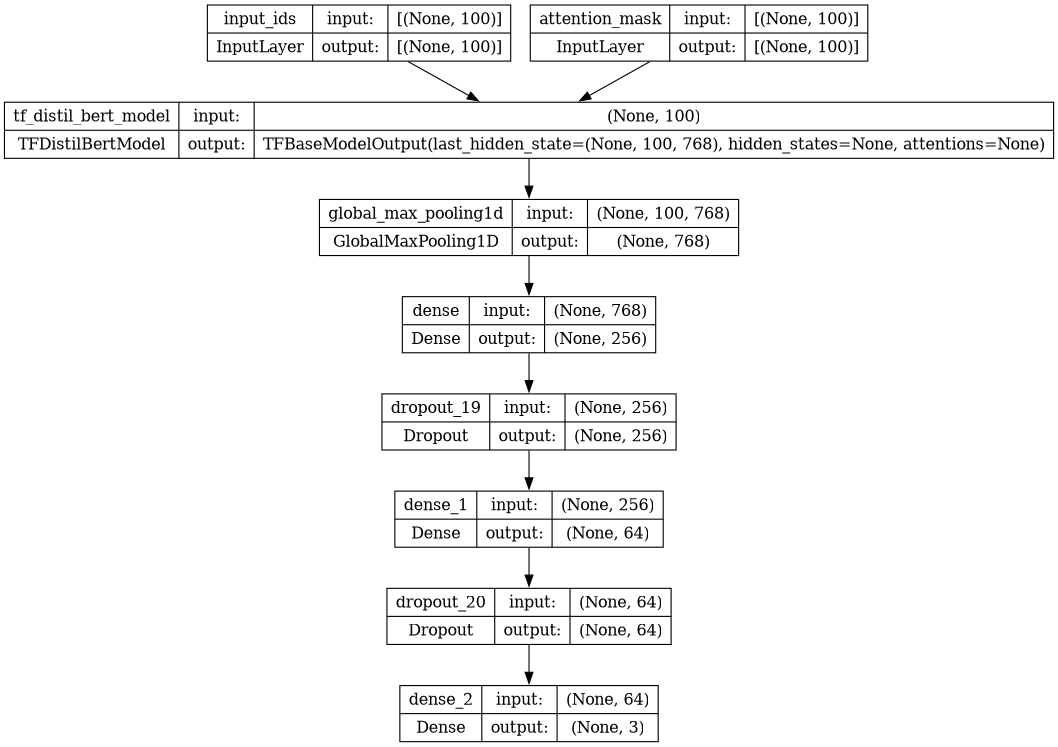

In [14]:
# plotting the model
tf.keras.utils.plot_model(model, show_shapes=True, dpi=80)

In [15]:
# training
hist = model.fit(train_dataset, validation_data = valid_dataset, epochs = 5, callbacks = my_callbacks)

Epoch 1/5
17/17 [==============================] - 223s 13s/step - loss: 0.8304 - acc: 0.5822 - val_loss: 0.4350 - val_acc: 0.7873
Epoch 2/5
17/17 [==============================] - 209s 12s/step - loss: 0.3910 - acc: 0.8225 - val_loss: 0.3313 - val_acc: 0.8676
Epoch 3/5
17/17 [==============================] - 204s 12s/step - loss: 0.2671 - acc: 0.8911 - val_loss: 0.3366 - val_acc: 0.8690
Epoch 4/5
17/17 [==============================] - 203s 12s/step - loss: 0.2085 - acc: 0.9136 - val_loss: 0.2858 - val_acc: 0.8831
Epoch 5/5
17/17 [==============================] - 206s 12s/step - loss: 0.1450 - acc: 0.9437 - val_loss: 0.3349 - val_acc: 0.8986


# <span style="color:#e74c3c;"> Test </span>  Predictions

In [16]:
# test predictions
pred = model.predict(test_dataset)
test_pred = np.argmax(pred, axis = 1)
y_test = test_data['encoded_category'].values

42/42 [==============================] - 135s 3s/step


In [17]:
# a function for calculating and plotting predictions 
def plot_prediction_results(y_true, y_pred, target_names = list(le.classes_)):
    
    mse = mean_squared_error(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'weighted')
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    clf = classification_report(y_true, y_pred, target_names = target_names)
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay(cm, display_labels = target_names)
    fig, axs = plt.subplots(figsize=(4,4))
    cmd.plot(ax=axs, cmap="bone", colorbar = False)

Mean Squared Error :	0.13776
Weighted F1 Score :	0.885
Accuracy Score :	88.589 %
----------------------------------------------------------------------

 Classification Report:
                       precision    recall  f1-score   support

             Economy       0.88      0.79      0.83       919
Science & Technology       0.81      0.89      0.85       896
              Sports       0.98      0.99      0.98       849

            accuracy                           0.89      2664
           macro avg       0.89      0.89      0.89      2664
        weighted avg       0.89      0.89      0.89      2664

----------------------------------------------------------------------

 Confusion Matrix: 



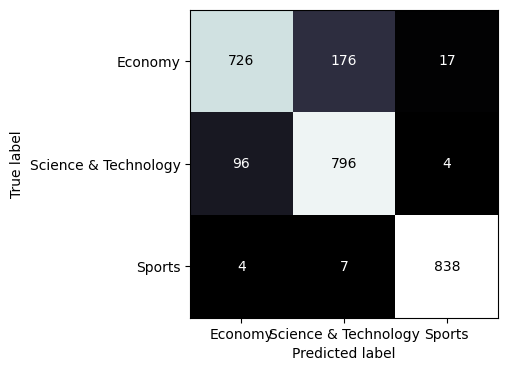

In [18]:
plot_prediction_results(y_test, test_pred)